In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the data

## NY Times

In [2]:
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
df = pd.read_csv(url, parse_dates=[0])  # Cols: date, state, fips, cases, deaths 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11564 entries, 0 to 11563
Data columns (total 5 columns):
date      11564 non-null datetime64[ns]
state     11564 non-null object
fips      11564 non-null int64
cases     11564 non-null int64
deaths    11564 non-null int64
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 451.8+ KB


The **fips** code can be used for getting the location info for the plots. Rest are self-understandable.

## Wikipedia population data

In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States_by_population'
pop_df = pd.read_html(url)[0]

pop_df.head()

Rank              State         Census population                   \
  Current 2010         State Estimate, July 1, 2019[8] April 1, 2010[9]   
0     1.0  1.0    California                  39512223         37253956   
1     2.0  2.0         Texas                  28995881         25145561   
2     3.0  4.0       Florida                  21477737         18801310   
3     4.0  3.0      New York                  19453561         19378102   
4     5.0  6.0  Pennsylvania                  12801989         12702379   

  Change, 2010–2019             Total U.S. House of Representatives Seats  \
    Percent[note 3]    Absolute Total U.S. House of Representatives Seats   
0              6.1%  +2,257,700                                        53   
1             15.3%  +3,850,320                                        36   
2             14.2%  +2,676,427                                        27   
3              0.4%     +75,459                                        27   
4              0.8%     +99,610                                        18   

  Estimated population per electoral vote, 2019[note 1]  \
  Estimated population per electoral vote, 2019[note 1]   
0                                             718404      
1                                             763050      
2                                             740611      
3                                             670812      
4                                             640099      

  Census population per House seat          \
                   Estimated, 2019    2010   
0                           745514  702885   
1                           805441  698503   
2                           795472  696468   
3                           720502  717707   
4                           711222  705715   

  Percent of the total U.S. population, 2019[note 2]  
  Percent of the total U.S. population, 2019[note 2]  
0                                             11.91%  
1                                              8.74%  
2                                              6.47%  
3                                              5.86%  
4                                              3.86%

In [4]:
pop_df = pop_df.iloc[:,2:4]
pop_df = pop_df.droplevel(0, axis=1)
pop_df.tail(10)

State Estimate, July 1, 2019[8]
50                                      Vermont                    623989
51                                      Wyoming                    578759
52                                         Guam               168,485[10]
53                          U.S. Virgin Islands               106,235[12]
54                     Northern Mariana Islands                51,433[14]
55                               American Samoa                49,437[16]
56                     Contiguous United States                 325386357
57                             The fifty states                 327533795
58                          Fifty states + D.C.                 328239523
59  Total U.S. (including D.C. and territories)                 331808807

### Pre-processing population data

In [5]:
# Checking states names that are same before merging

s_df = set(df.state.unique())
s_pop = set(pop_df.State)

intersect = s_df.intersection(s_pop)
intersect = list(intersect)
print(f'For {len(intersect)} states, the names are common.')

print(f'\nState names in population data not common are:')
for state in s_pop.difference(intersect):
    print(state)
print(f'\nState names in COVID-19 data not common are:')
for state in s_df.difference(intersect):
    print(state)

For 54 states, the names are common.

State names in population data not common are:
Fifty states + D.C.
American Samoa
U.S. Virgin Islands
Total U.S. (including D.C. and territories)
Contiguous United States
The fifty states

State names in COVID-19 data not common are:
Virgin Islands


It's best to remove the least populous territories as they're bound to underfit and the total counts as they won't be merged eventually. With data being sorted in the correct order, the data from `pop_df` before 52nd entry is enough. Thus, keeping only data till Wyoming for this study.

In [6]:
pop_df = pop_df[:52]
pop_df.tail()

State Estimate, July 1, 2019[8]
47          North Dakota                    762062
48                Alaska                    731545
49  District of Columbia                    705749
50               Vermont                    623989
51               Wyoming                    578759

In [7]:
import re
import warnings
warnings.filterwarnings("ignore")

def pre_process(total_pop):
    '''Pre-process population values where in some cases the references might 
    have '...[..]' pattern signifying reference
    '''
    try:
        num = int(total_pop)
    except:
        m = re.match(r'\d+[\d+]', total_pop)
        num = int(m.group(0))

    return num

pop_df.rename(columns={pop_df.columns[1]: 'Recent_population'}, inplace=True)

pop_df['Recent_population'] = pop_df['Recent_population'].apply(pre_process)

pop_df.sort_values(by='Recent_population')
pop_df.head()

State  Recent_population
0    California           39512223
1         Texas           28995881
2       Florida           21477737
3      New York           19453561
4  Pennsylvania           12801989

# Pre-processing

Either merge with population data or just per day analysis

## Merge with population data

Do if demographic data is needed (skipping for now)

In [8]:
df = df.sort_values(by=['state', 'date'])#.set_index('date')
df

date    state  fips  cases  deaths
586   2020-03-13  Alabama     1      6       0
637   2020-03-14  Alabama     1     12       0
689   2020-03-15  Alabama     1     23       0
742   2020-03-16  Alabama     1     29       0
795   2020-03-17  Alabama     1     39       0
...          ...      ...   ...    ...     ...
11178 2020-09-21  Wyoming    56   4944      49
11233 2020-09-22  Wyoming    56   5016      49
11288 2020-09-23  Wyoming    56   5169      50
11343 2020-09-24  Wyoming    56   5305      50
11398 2020-09-25  Wyoming    56   5420      50

[11399 rows x 5 columns]

In [184]:
data = pd.merge(df, pop_df, left_on='state', right_on='State').drop(columns='State')

data

date    state  fips  cases  deaths  Recent_population
0     2020-03-13  Alabama     1      6       0            4903185
1     2020-03-14  Alabama     1     12       0            4903185
2     2020-03-15  Alabama     1     23       0            4903185
3     2020-03-16  Alabama     1     29       0            4903185
4     2020-03-17  Alabama     1     39       0            4903185
...          ...      ...   ...    ...     ...                ...
10821 2020-09-21  Wyoming    56   4944      49             578759
10822 2020-09-22  Wyoming    56   5016      49             578759
10823 2020-09-23  Wyoming    56   5169      50             578759
10824 2020-09-24  Wyoming    56   5305      50             578759
10825 2020-09-25  Wyoming    56   5420      50             578759

[10826 rows x 6 columns]

# Analysis

 ## State-wise Analysis

For the model, before scaling, it's best to see if state population indicates some pattern

Pearson coefficient for cases:0.956
Pearson coefficient for deaths:0.764


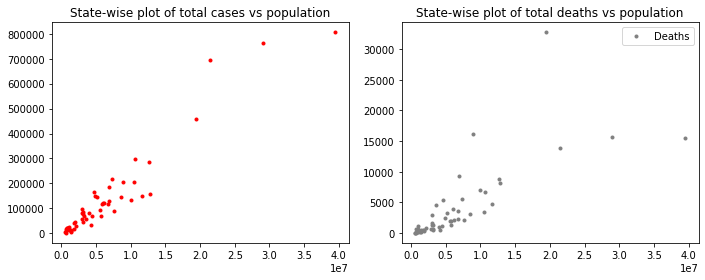

In [10]:
import scipy.stats

total_pop = []
total_cases = []
total_deaths = []

for s in data.state.unique():
    sub = data[data.state==s].iloc[-1]
    total_pop.append(sub.Recent_population)
    total_cases.append(sub.cases)
    total_deaths.append(sub.deaths)

fig = plt.figure(figsize=(10,4))    
ax1 = fig.add_subplot(1,2,1)
ax1.plot(total_pop, total_cases, 'r.', label='Cases')    
ax1.set_title('State-wise plot of total cases vs population')
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('State-wise plot of total deaths vs population')
ax2.plot(total_pop, total_deaths, 'grey', ls='', marker='.', label='Deaths')    
ax2.legend()
fig.tight_layout()

pearson_cases, _ = scipy.stats.pearsonr(total_pop, total_cases)
pearson_deaths, _ = scipy.stats.pearsonr(total_pop, total_deaths)

print(f'Pearson coefficient for cases:{pearson_cases:0.3f}')
print(f'Pearson coefficient for deaths:{pearson_deaths:0.3f}')

For the reported cases, a linear trend with respect to population is seen. For the total deaths, the trend is that some states have handled better than the rest, and although the Pearson coefficient is only ~0.76, it is still a good indicator.

In [185]:
## Adding per capita columns based on recent population

data['cases_per_capita'] = data.cases / data.Recent_population
data['deaths_per_capita'] = data.deaths / data.Recent_population

data = data.set_index('date')

data.head()

state  fips  cases  deaths  Recent_population  cases_per_capita  \
date                                                                            
2020-03-13  Alabama     1      6       0            4903185          0.000001   
2020-03-14  Alabama     1     12       0            4903185          0.000002   
2020-03-15  Alabama     1     23       0            4903185          0.000005   
2020-03-16  Alabama     1     29       0            4903185          0.000006   
2020-03-17  Alabama     1     39       0            4903185          0.000008   

            deaths_per_capita  
date                           
2020-03-13                0.0  
2020-03-14                0.0  
2020-03-15                0.0  
2020-03-16                0.0  
2020-03-17                0.0

Let's analyze the growth pattern across various states

Referring the great tutorial in: https://www.kaggle.com/sumi25/understand-arima-and-tune-p-d-q

In [12]:
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot

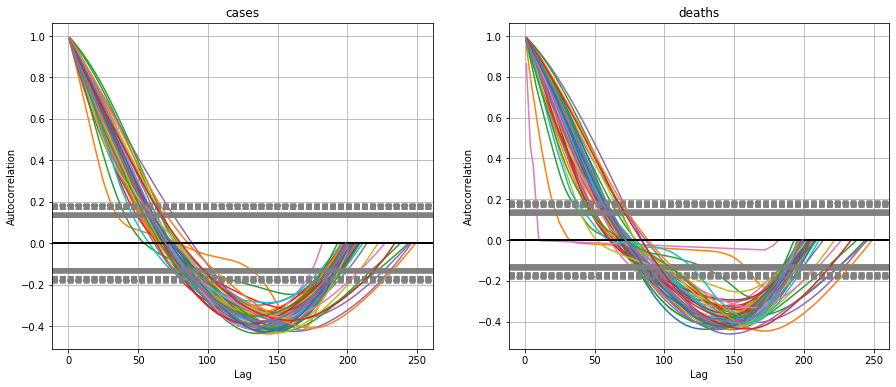

In [13]:
fig, axes = plt.subplots(1,2, figsize=(15,6))

colname = ['cases', 'deaths']

for c, col in enumerate(colname):
    for i, s in enumerate(df.state.unique()):
        subset = df[df.state == s][col]
        autocorrelation_plot(subset, ax=axes[c])
        axes[c].set_title(col)

The auto-correlation is obviously very high. At a lag of 10 for all states, the auto-correlation for cases is above 0.75 for most cases. 

We can confirm this with a lag plot for all states

In [14]:
def plot_fn(colname, plot_type, **kwargs):
    # 13 rows and 4 cols
    fig, axes = plt.subplots(nrows=13, ncols=4, sharex=kwargs['sharex'], constrained_layout=True,
                             sharey=kwargs['sharex'], figsize=(15,45))
    
    for i, s in enumerate(data.state.unique()):
        r, c = i//4, i%4
        subset = data[data.state == s][colname]
        if plot_type=='autocorr':
            autocorrelation_plot(subset, ax=axes[r,c])
            axes[r,c].set_title(s)
            
        if plot_type=='lag':
            lag = kwargs['lag']
            lag_plot(subset, lag=lag, ax=axes[r,c])
            axes[r,c].set_title(f'Lag: {lag} for {s}')
                                

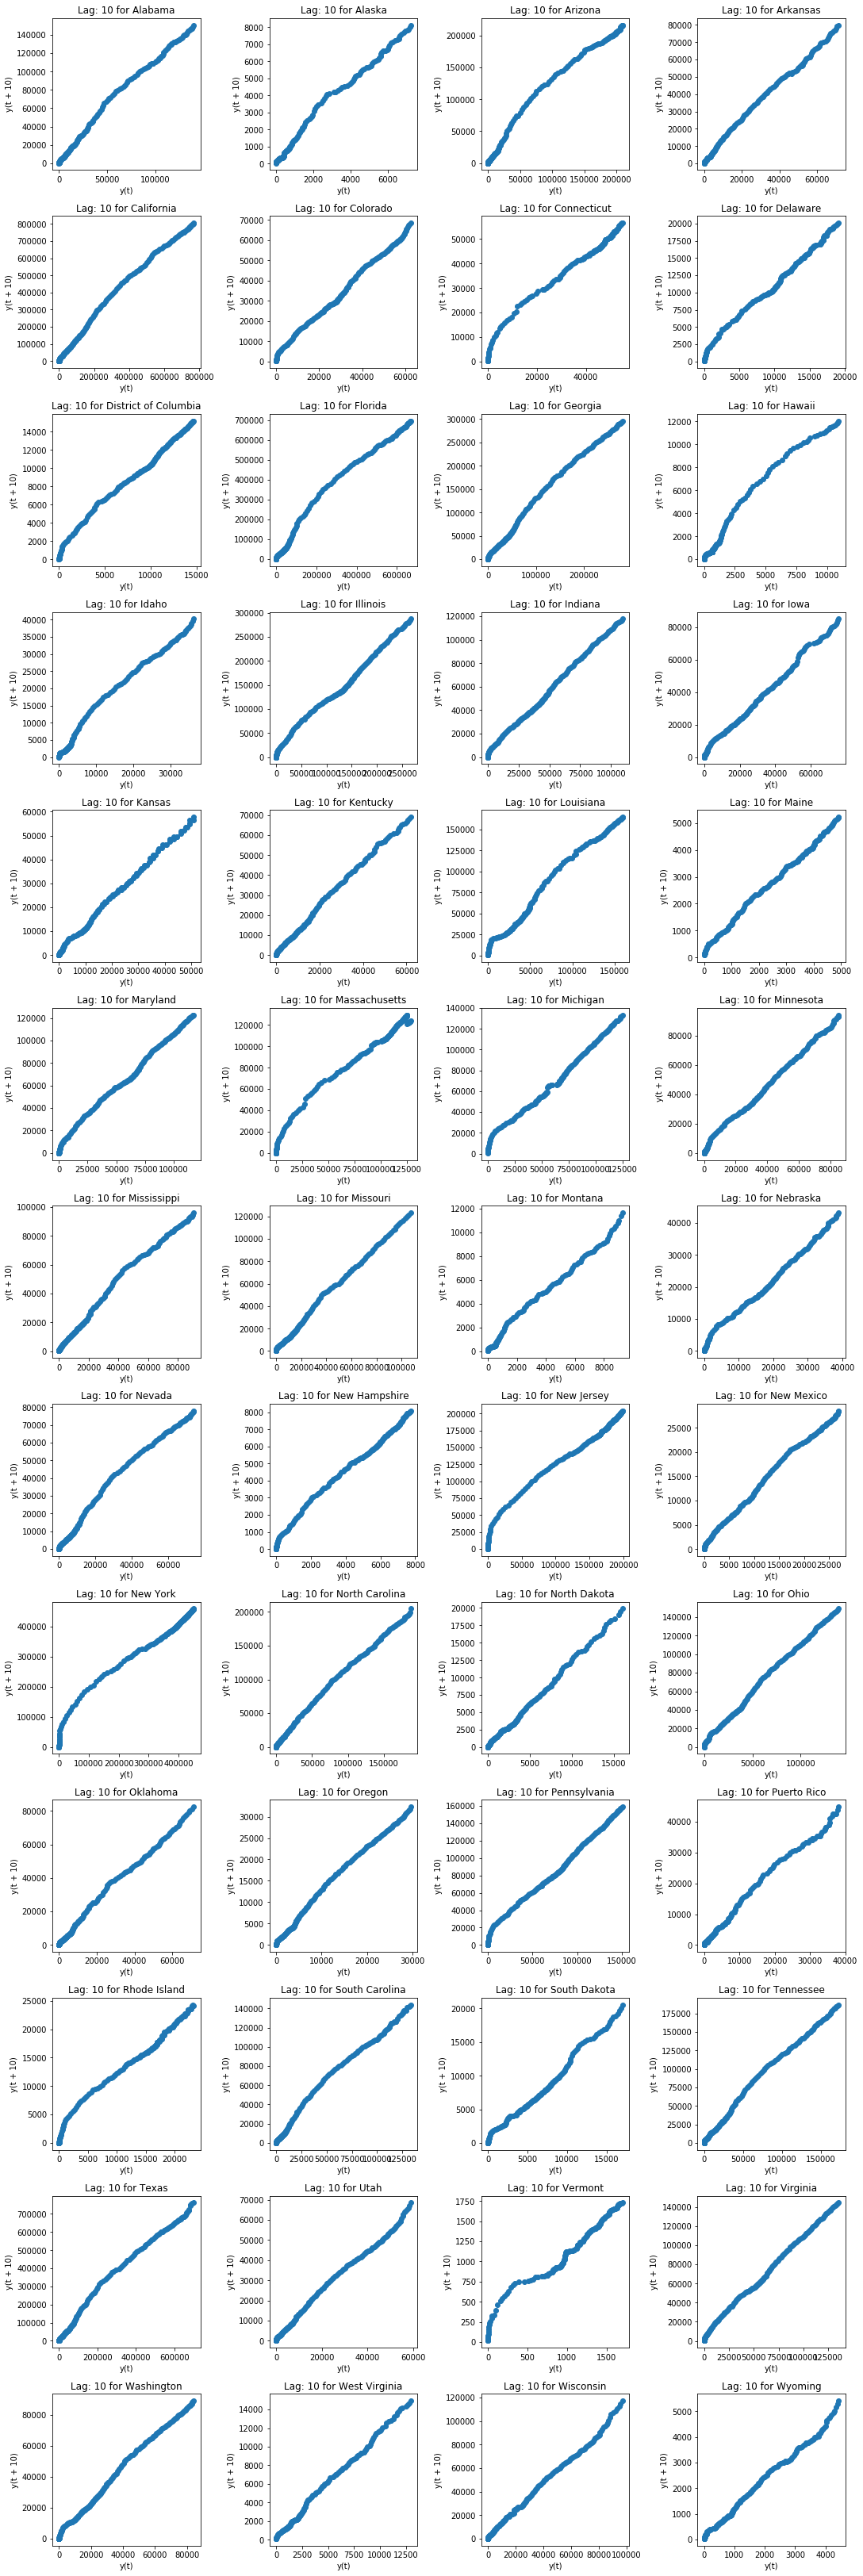

In [15]:
# plot_fn('cases', 'autocorr', **{'sharex': True, 'sharey': True})
plot_fn('cases', 'lag', **{'lag': 10, 'sharex': False, 'sharey': False})

As expected from the type of data and the lag plot, all the states show similar trend. All the states start stabilizing as seen below

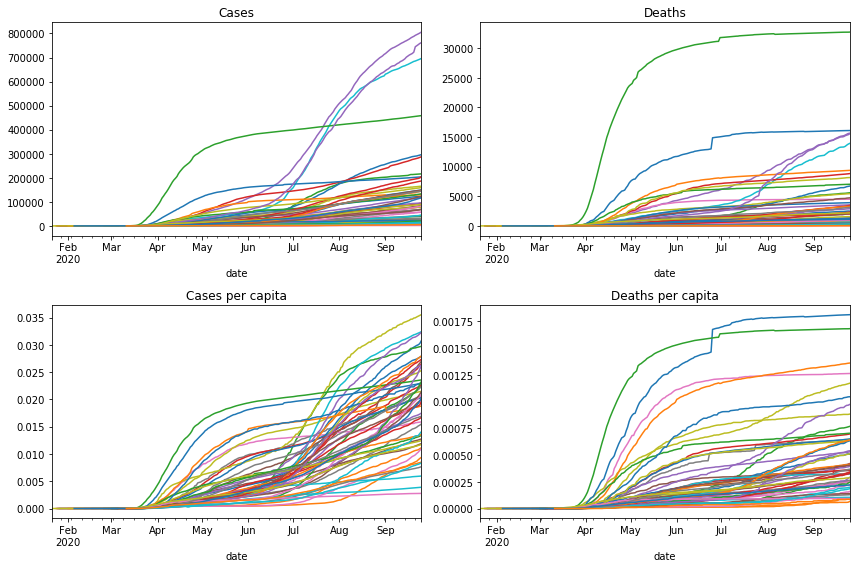

In [16]:
states_df_group = data.groupby('state')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

# Actual
states_df_group.cases.plot(ax=axes[0,0]);
axes[0,0].set_title('Cases')
states_df_group.deaths.plot(ax=axes[0,1]);
axes[0,1].set_title('Deaths')

# Per capita
states_df_group.cases_per_capita.plot(ax=axes[1,0]);
axes[1,0].set_title('Cases per capita')
states_df_group.deaths_per_capita.plot(ax=axes[1,1]);
axes[1,1].set_title('Deaths per capita')

fig.tight_layout()

Certainly the per capita results have made all the graphs similar and is a good normalization to make a single model. 
Min max scaling won't affect much because the values would just scale up to 1. Learning parameters would mostly handly this

## Daily analysis for lag parameters

In [17]:
state_df = df[df.state=='Washington']
state_df

date       state  fips  cases  deaths
0     2020-01-21  Washington    53      1       0
1     2020-01-22  Washington    53      1       0
2     2020-01-23  Washington    53      1       0
4     2020-01-24  Washington    53      1       0
7     2020-01-25  Washington    53      1       0
...          ...         ...   ...    ...     ...
11175 2020-09-21  Washington    53  86803    2137
11230 2020-09-22  Washington    53  87233    2163
11285 2020-09-23  Washington    53  88042    2175
11340 2020-09-24  Washington    53  88597    2175
11395 2020-09-25  Washington    53  89149    2193

[249 rows x 5 columns]

In [18]:
# Adding daily parameters for analysis

state_df['daily_cases']=state_df.cases.diff()
state_df['daily_deaths']=state_df.deaths.diff()
state_df

state_df['daily_cases'].fillna(state_df['cases'], inplace=True)
state_df['daily_deaths'].fillna(state_df['deaths'], inplace=True)
state_df

date       state  fips  cases  deaths  daily_cases  daily_deaths
0     2020-01-21  Washington    53      1       0          1.0           0.0
1     2020-01-22  Washington    53      1       0          0.0           0.0
2     2020-01-23  Washington    53      1       0          0.0           0.0
4     2020-01-24  Washington    53      1       0          0.0           0.0
7     2020-01-25  Washington    53      1       0          0.0           0.0
...          ...         ...   ...    ...     ...          ...           ...
11175 2020-09-21  Washington    53  86803    2137        634.0           7.0
11230 2020-09-22  Washington    53  87233    2163        430.0          26.0
11285 2020-09-23  Washington    53  88042    2175        809.0          12.0
11340 2020-09-24  Washington    53  88597    2175        555.0           0.0
11395 2020-09-25  Washington    53  89149    2193        552.0          18.0

[249 rows x 7 columns]

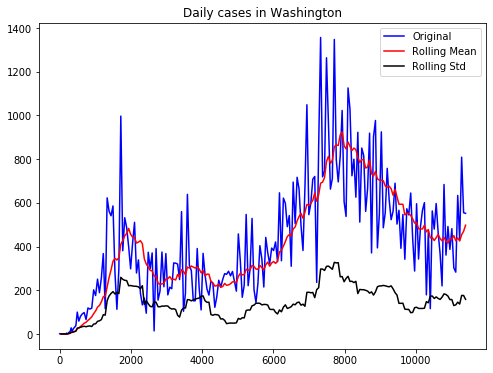

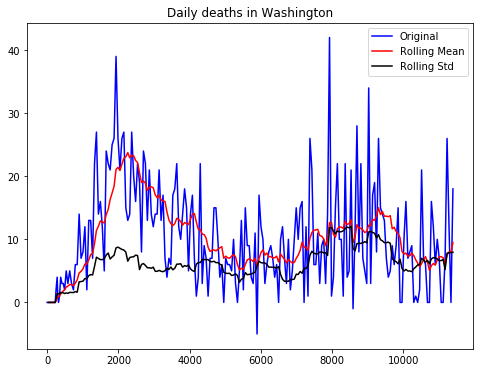

In [19]:
def test_stationarity(timeseries, title, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(8, 6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(f'Daily {title} in Washington')
    plt.show()
    
test_stationarity(state_df['daily_cases'], title='cases')    
test_stationarity(state_df['daily_deaths'], title='deaths')    

The series is non-seasonal due to limited time observed, but it is non-stationary.

Analysis for daily cases:


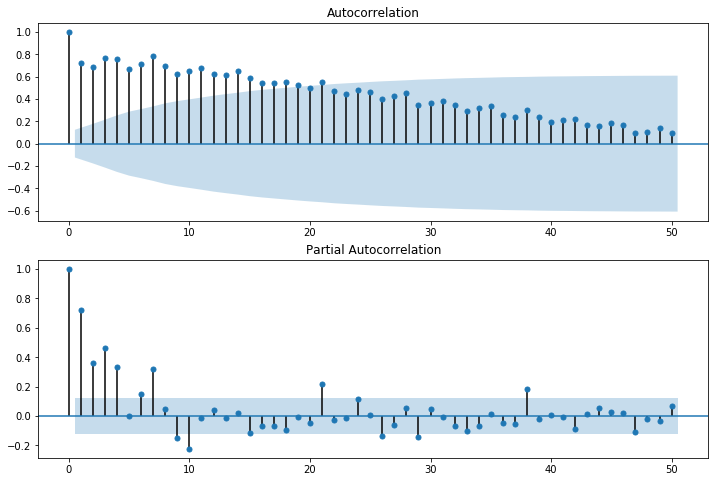

In [20]:
import statsmodels.api as sm

print('Analysis for daily cases:')
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(state_df.daily_cases, lags=50, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(state_df.daily_cases, lags=50, ax=ax2)

Here, the PACF displays a sharp cutoff while the ACF decays more slowly. Hence, an AR model will work for our situation with the cutoff being after 5 lag periods in PACF. Also, we have taken a difference over previous 1 period. Thus, the parameters for our time-series is:

|parameter|value|
|---|---|
|p|5|
|d|1|
|q|0|


Refer: https://people.duke.edu/~rnau/411arim3.htm

Analysis for daily deaths:


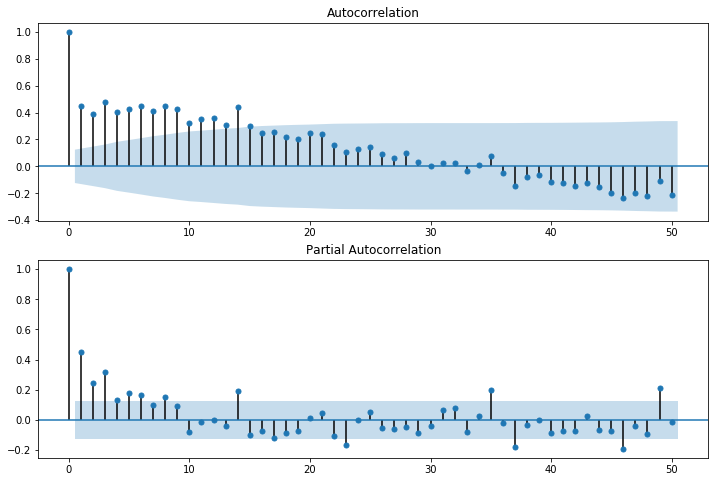

In [21]:
print('Analysis for daily deaths:')

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(state_df.daily_deaths, lags=50, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(state_df.daily_deaths, lags=50, ax=ax2)

Even for estimation of deaths, we observe similar pattern, with the value of p being 4 instead.

# Model

## ARIMA Model

In [22]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [26]:
def ARIMA_forecast(series, split=0.8, **kwargs):
    L = len(series)
    size = int(np.floor(L*split))
    n_preds = L - size
    
#     size = L - n_preds

    train, test = list(series[:size]), list(series[size:])
    
    mode = kwargs.get('mode', 'Single')
    order = kwargs.get('order', (5,1,0))
    
    history = list(train)#[x for x in train]
    predictions = list()
    
    # 1 by 1
    if mode=='Single':
        predictions, stderr, bounds = [],[],[]
#         print('1 by 1')
        for t in range(len(test)):
            model = ARIMA(history, order=order)
            model_fit = model.fit(disp=0)
            output = model_fit.forecast()
            ypred = round(output[0][0])
            predictions.append(ypred)
            stderr.append(output[1])
            bounds.append(output[2])
            obs = test[t]
            history.append(obs)
            # print(f'predicted={ypred}, expected={obs}')
    
        results = (np.squeeze(predictions), np.squeeze(stderr), np.squeeze(bounds))               
        error = mean_squared_error(test, predictions)
        print(error)
        
    # All at once
    elif mode=='All':
#         print('All at once')
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit(disp=0)
        results = model_fit.forecast(steps=n_preds)
        predictions, stderr, bounds = results
        

        error = mean_squared_error(test, predictions)
#         print(error)
#     print(f'Test MSE: {error:0.3f}')
    
    return {'error': error,
            'train': train,
            'test': test,
            'results': results,
           }

# we get daily cases by making the model with cases have d=1. So the result of daily_cases having d=0 is the same
output = ARIMA_forecast(state_df.cases, 0.9, **{'mode':'All'})    

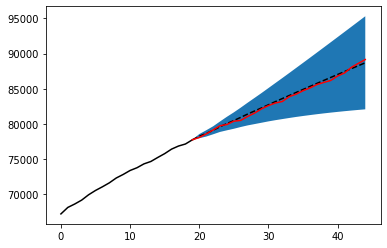

In [27]:
def plot_curve(axis, train, test, results):
    pred, stderr, bounds = results
    
    xticks = list(range(len(train)+len(test))) # Temporary
    
    # To merge with first column
    test = np.insert(test, 0, train[-1])
    pred = np.insert(pred, 0, train[-1])
    bounds = np.insert(bounds, 0, train[-1], axis=0)   # insert 0 at 0th row
    axis.plot(xticks[:len(train)], train, 'k')
    axis.plot(xticks[len(train)-1:], pred, '--k')    
    axis.plot(xticks[len(train)-1:], test, 'r')    
    axis.fill_between(xticks[len(train)-1:], bounds[:,0], bounds[:,1])    

fig = plt.figure()
ax = fig.add_subplot(111)
plot_curve(ax, output['train'][-20:], output['test'], output['results'])    

Forecast of: cases_per_capita


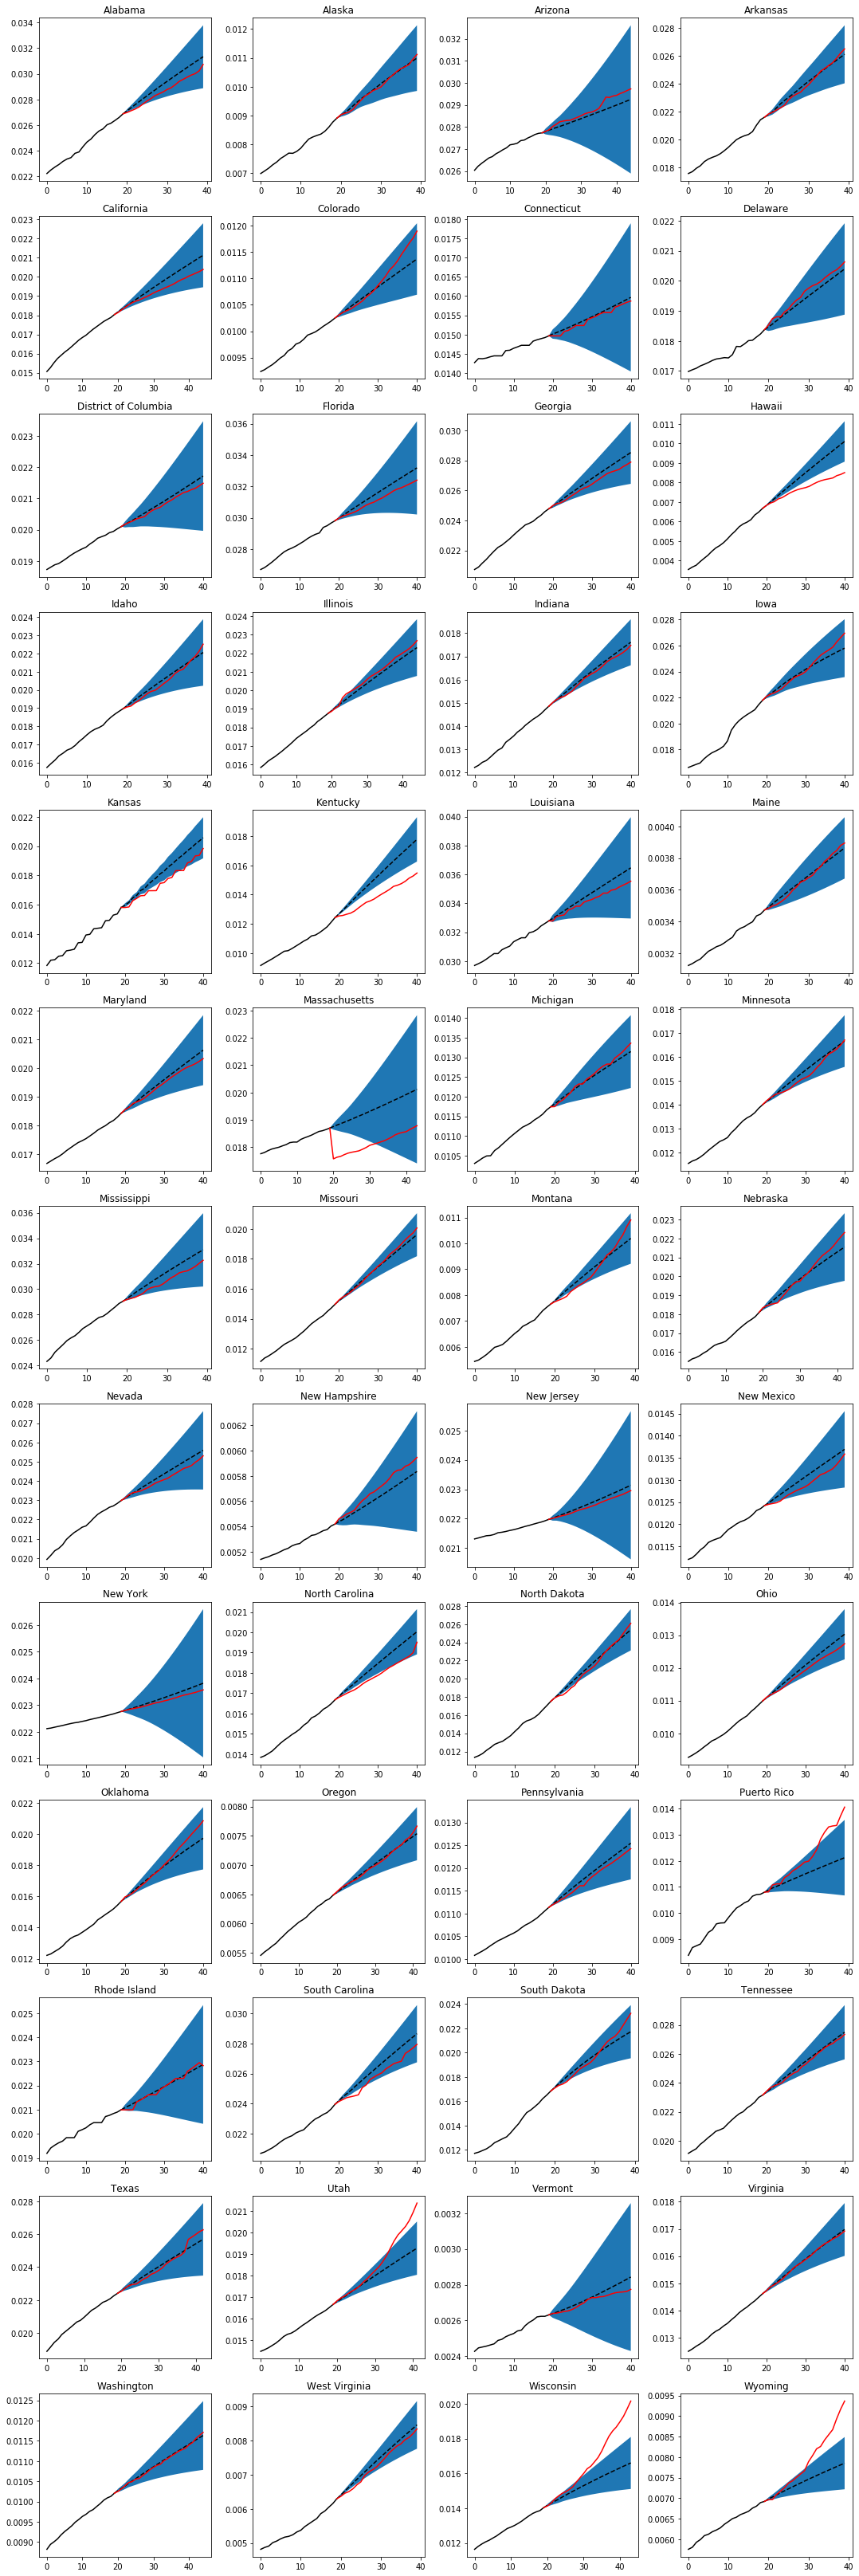

In [31]:
def all_forecasts(df, col, **kwargs):
    total=0
    print('Forecast of:', col)
    fig, axes = plt.subplots(nrows=13, ncols=4, sharex=False, constrained_layout=True,
                             sharey=False, figsize=(15,45))
    
    for i, s in enumerate(df.state.unique()):
        state_df = df[df.state==s]
        output = ARIMA_forecast(state_df[col], 0.9, **kwargs)  
        
        r, c = i//4, i%4
        
        plot_curve(axes[r,c], output['train'][-20:], output['test'], output['results'])    
#         subset = data[data.state == s][colname]
#         autocorrelation_plot(subset, ax=axes[r,c])
        axes[r,c].set_title(s)
        
#         print(f'MSE for {s}: {results[0]}')
#         total+=results[0]
    fig.tight_layout()
    
kwargs = {'mode':'All'}
all_forecasts(data, 'cases_per_capita', **kwargs)        

Forecast of: deaths_per_capita


C:\Users\ksmai\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\ksmai\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\ksmai\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\ksmai\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\ksmai\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

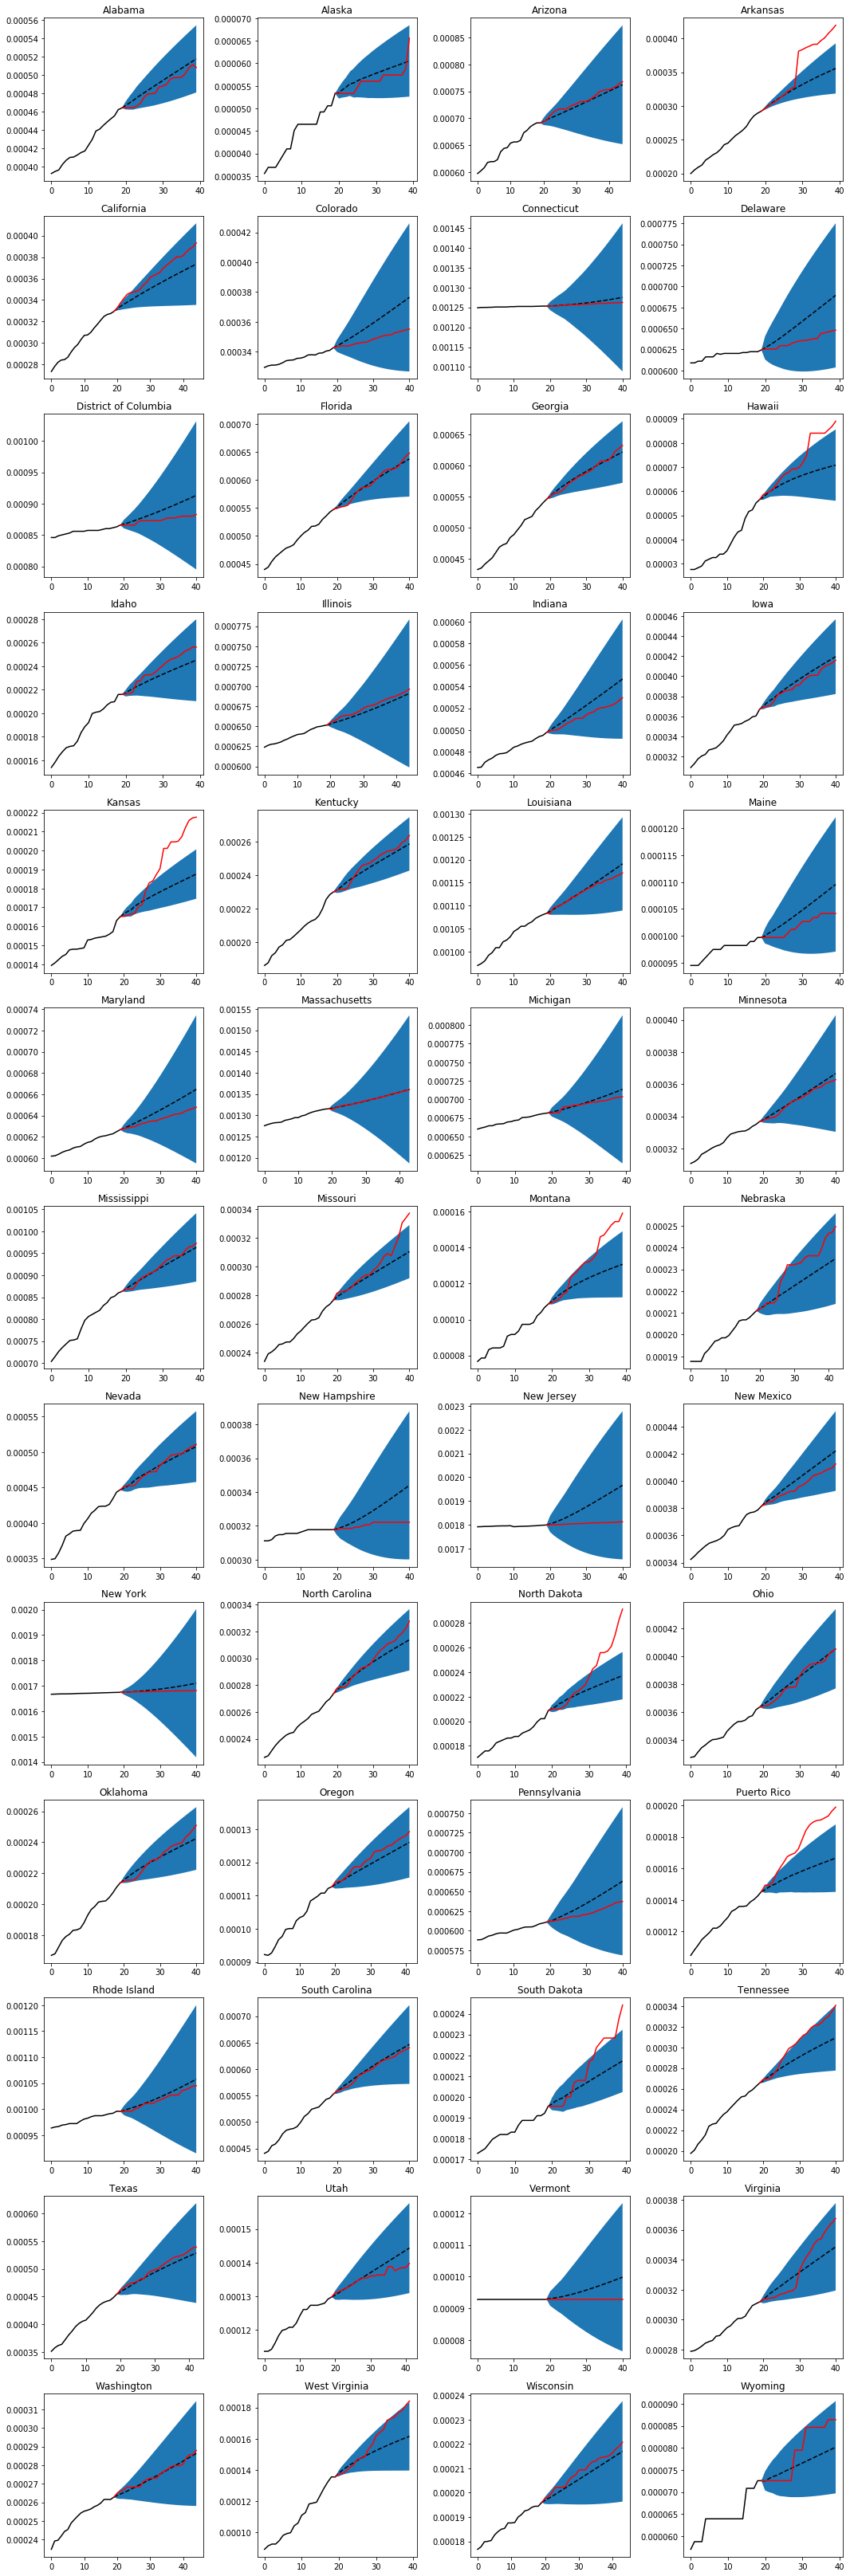

In [34]:
all_forecasts(data, 'deaths_per_capita', **kwargs)        

## RNN Model

In [194]:
temp = data.copy()
temp

state  fips  cases  deaths  Recent_population  cases_per_capita  \
date                                                                            
2020-03-13  Alabama     1      6       0            4903185          0.000001   
2020-03-14  Alabama     1     12       0            4903185          0.000002   
2020-03-15  Alabama     1     23       0            4903185          0.000005   
2020-03-16  Alabama     1     29       0            4903185          0.000006   
2020-03-17  Alabama     1     39       0            4903185          0.000008   
...             ...   ...    ...     ...                ...               ...   
2020-09-21  Wyoming    56   4944      49             578759          0.008542   
2020-09-22  Wyoming    56   5016      49             578759          0.008667   
2020-09-23  Wyoming    56   5169      50             578759          0.008931   
2020-09-24  Wyoming    56   5305      50             578759          0.009166   
2020-09-25  Wyoming    56   5420      50             578759          0.009365   

            deaths_per_capita  
date                           
2020-03-13           0.000000  
2020-03-14           0.000000  
2020-03-15           0.000000  
2020-03-16           0.000000  
2020-03-17           0.000000  
...                       ...  
2020-09-21           0.000085  
2020-09-22           0.000085  
2020-09-23           0.000086  
2020-09-24           0.000086  
2020-09-25           0.000086  

[10826 rows x 7 columns]

In [195]:
def get_daily(df, col):
    for s in df.state.unique():
        
        df['daily_'+col]=df[col].diff()
        df['daily_'+col].fillna(df[col], inplace=True)

    return df

get_daily(temp, 'cases')    

state  fips  cases  deaths  Recent_population  cases_per_capita  \
date                                                                            
2020-03-13  Alabama     1      6       0            4903185          0.000001   
2020-03-14  Alabama     1     12       0            4903185          0.000002   
2020-03-15  Alabama     1     23       0            4903185          0.000005   
2020-03-16  Alabama     1     29       0            4903185          0.000006   
2020-03-17  Alabama     1     39       0            4903185          0.000008   
...             ...   ...    ...     ...                ...               ...   
2020-09-21  Wyoming    56   4944      49             578759          0.008542   
2020-09-22  Wyoming    56   5016      49             578759          0.008667   
2020-09-23  Wyoming    56   5169      50             578759          0.008931   
2020-09-24  Wyoming    56   5305      50             578759          0.009166   
2020-09-25  Wyoming    56   5420      50             578759          0.009365   

            deaths_per_capita  daily_cases  
date                                        
2020-03-13           0.000000          6.0  
2020-03-14           0.000000          6.0  
2020-03-15           0.000000         11.0  
2020-03-16           0.000000          6.0  
2020-03-17           0.000000         10.0  
...                       ...          ...  
2020-09-21           0.000085         73.0  
2020-09-22           0.000085         72.0  
2020-09-23           0.000086        153.0  
2020-09-24           0.000086        136.0  
2020-09-25           0.000086        115.0  

[10826 rows x 8 columns]

In [197]:
temp[temp.state=='Wyoming']

state  fips  cases  deaths  Recent_population  cases_per_capita  \
date                                                                            
2020-03-11  Wyoming    56      1       0             578759          0.000002   
2020-03-12  Wyoming    56      1       0             578759          0.000002   
2020-03-13  Wyoming    56      2       0             578759          0.000003   
2020-03-14  Wyoming    56      3       0             578759          0.000005   
2020-03-15  Wyoming    56      3       0             578759          0.000005   
...             ...   ...    ...     ...                ...               ...   
2020-09-21  Wyoming    56   4944      49             578759          0.008542   
2020-09-22  Wyoming    56   5016      49             578759          0.008667   
2020-09-23  Wyoming    56   5169      50             578759          0.008931   
2020-09-24  Wyoming    56   5305      50             578759          0.009166   
2020-09-25  Wyoming    56   5420      50             578759          0.009365   

            deaths_per_capita  daily_cases  
date                                        
2020-03-11           0.000000    -117354.0  
2020-03-12           0.000000          0.0  
2020-03-13           0.000000          1.0  
2020-03-14           0.000000          1.0  
2020-03-15           0.000000          0.0  
...                       ...          ...  
2020-09-21           0.000085         73.0  
2020-09-22           0.000085         72.0  
2020-09-23           0.000086        153.0  
2020-09-24           0.000086        136.0  
2020-09-25           0.000086        115.0  

[199 rows x 8 columns]

In [174]:
states = data.state.unique()
d=data[data.state==states[0]][ ['cases_per_capita', 'deaths_per_capita']]

d['daily_cases']=d.cases_per_capita.diff()
d['daily_deaths']=d.deaths_per_capita.diff()

d['daily_cases'].fillna(d['cases_per_capita'], inplace=True)
d['daily_deaths'].fillna(d['deaths_per_capita'], inplace=True)
d

cases_per_capita  deaths_per_capita  daily_cases  daily_deaths
date                                                                      
2020-03-13          0.000001           0.000000     0.000001  0.000000e+00
2020-03-14          0.000002           0.000000     0.000001  0.000000e+00
2020-03-15          0.000005           0.000000     0.000002  0.000000e+00
2020-03-16          0.000006           0.000000     0.000001  0.000000e+00
2020-03-17          0.000008           0.000000     0.000002  0.000000e+00
...                      ...                ...          ...           ...
2020-09-21          0.029732           0.000497     0.000167  4.078981e-07
2020-09-22          0.029896           0.000501     0.000164  3.671083e-06
2020-09-23          0.030012           0.000507     0.000116  6.322421e-06
2020-09-24          0.030226           0.000511     0.000215  3.671083e-06
2020-09-25          0.030727           0.000508     0.000500 -3.059236e-06

[197 rows x 4 columns]

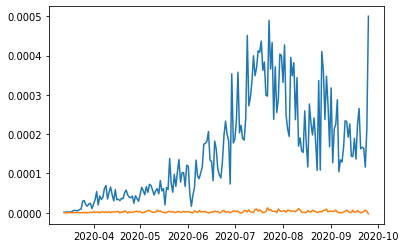

In [176]:
plt.plot(d.index, d.daily_cases)
plt.plot(d.index, d.daily_deaths)

In [201]:
temp.groupby('state').rolling(5).mean()

fips   cases  deaths  Recent_population  cases_per_capita  \
state   date                                                                    
Alabama 2020-03-13   NaN     NaN     NaN                NaN               NaN   
        2020-03-14   NaN     NaN     NaN                NaN               NaN   
        2020-03-15   NaN     NaN     NaN                NaN               NaN   
        2020-03-16   NaN     NaN     NaN                NaN               NaN   
        2020-03-17   1.0    21.8     0.0          4903185.0          0.000004   
...                  ...     ...     ...                ...               ...   
Wyoming 2020-09-21  56.0  4798.8    49.0           578759.0          0.008292   
        2020-09-22  56.0  4871.6    49.0           578759.0          0.008417   
        2020-09-23  56.0  4956.0    49.2           578759.0          0.008563   
        2020-09-24  56.0  5061.0    49.4           578759.0          0.008745   
        2020-09-25  56.0  5170.8    49.6           578759.0          0.008934   

                    deaths_per_capita  daily_cases  
state   date                                        
Alabama 2020-03-13                NaN          NaN  
        2020-03-14                NaN          NaN  
        2020-03-15                NaN          NaN  
        2020-03-16                NaN          NaN  
        2020-03-17           0.000000          7.8  
...                               ...          ...  
Wyoming 2020-09-21           0.000085         75.6  
        2020-09-22           0.000085         72.8  
        2020-09-23           0.000085         84.4  
        2020-09-24           0.000085        105.0  
        2020-09-25           0.000086        109.8  

[10826 rows x 7 columns]

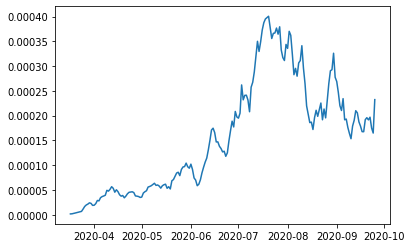

In [198]:
roll = d.rolling(5).mean()
plt.plot(roll.index, roll.daily_cases)

In [169]:
win = 7
d=d[ ['cases_per_capita', 'deaths_per_capita']]
d
# X,Y=[],[]
# for r in range(win, len(d)):
    
#     y = d.iloc[r]
#     x = d.iloc[r-win:r] 
#     if r>=7 :
#         X.append(x.values)
#         Y.append(y.values)        
        
        

cases_per_capita  deaths_per_capita
date                                           
2020-03-13          0.000001           0.000000
2020-03-14          0.000002           0.000000
2020-03-15          0.000005           0.000000
2020-03-16          0.000006           0.000000
2020-03-17          0.000008           0.000000
...                      ...                ...
2020-09-21          0.029732           0.000497
2020-09-22          0.029896           0.000501
2020-09-23          0.030012           0.000507
2020-09-24          0.030226           0.000511
2020-09-25          0.030727           0.000508

[197 rows x 2 columns]

In [147]:
import torch
from torch.utils.data import Dataset, DataLoader


class TimeSeriesDataset(Dataset):
    
    def __init__(self, data, window=7, 
                 columns = ['cases_per_capita', 'deaths_per_capita']):  # Using a weekly window
        self.data = data
        self.window = window
        self.columns = columns
        self.X, self.Y = self.create_time_series_data()
        
    def create_time_series_data(self):
        # We want to learn features independent of states
        X,Y=[],[]

        states = data.state.unique()
        
        for s in states:
            d = data[data.state==s][self.columns]        
            for r in range(self.window, len(d)):
                x = d.iloc[r-self.window:r] 
                y = d.iloc[r]
                X.append(x.values)
                Y.append(y.values)        

        return torch.tensor(X, dtype=torch.double), torch.tensor(Y, dtype=torch.double)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [163]:
# Loading entire dataset for now
WINDOW = 5
COLUMNS = ['cases_per_capita', 'deaths_per_capita']
COLUMNS = ['cases', 'deaths']

train_dataset = TimeSeriesDataset(data, window=WINDOW, columns=COLUMNS)
train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=False)

In [164]:
import torch.nn as nn
import torch.nn.functional as F

class LSTMPredictor(nn.Module):
    
    def __init__(self, window, input_size, output_size):
        
        super(LSTMPredictor, self).__init__()
        
        # Adding defaults for now
        self.window=window
        self.input_size = 2  # For the 2 columns
        self.output_size = 2 # Keep the same
        
        self.lstm_block = nn.LSTM(input_size, 
                             output_size,
                             batch_first=True,
                             num_layers=3,
                             dropout=0.3)
        
        self.lin1 = nn.Linear(self.output_size*self.window, self.output_size)
        self.lin2 = nn.Linear(self.output_size, self.output_size)
        
    def forward(self, x):

        lstm_out, _ = self.lstm_block(x)  # '_' : skipping tuple of hidden state and cell state

        x = lstm_out.reshape(-1, self.output_size*self.window)
        x = F.relu(self.lin1(x))
        x = F.dropout(x)
        return self.lin2(x)

In [165]:
# Initialize losses
model = LSTMPredictor(window=WINDOW, input_size=2, output_size=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
# (optimizer, 'min')
MSE = torch.nn.MSELoss()

In [166]:
def train(dataloader):
    
    model.train()
    
    for epoch in range(10):
        
        scheduler.step()
        total_MSE = 0
        for i, batch in enumerate(dataloader):
            
            optimizer.zero_grad()
            x, y = batch
            out = model(x.float())

            loss = MSE(out, y.float())
            print(out[0], y[0])
            loss.backward()
            optimizer.step()
            
            total_MSE += loss.item()
            
        print(f'Epoch {epoch}, MSE loss: {total_MSE}')
        
train(train_dataloader)

tensor([0.3234, 0.3301], grad_fn=<SelectBackward>) tensor([51.,  0.], dtype=torch.float64)
tensor([0.3240, 0.3298], grad_fn=<SelectBackward>) tensor([2197.,   64.], dtype=torch.float64)
tensor([0.4038, 0.5063], grad_fn=<SelectBackward>) tensor([6539.,  228.], dtype=torch.float64)
tensor([0.3279, 0.3353], grad_fn=<SelectBackward>) tensor([11771.,   488.], dtype=torch.float64)
tensor([0.4055, 0.5080], grad_fn=<SelectBackward>) tensor([20043.,   689.], dtype=torch.float64)
tensor([0.4064, 0.5089], grad_fn=<SelectBackward>) tensor([34183.,   907.], dtype=torch.float64)
tensor([0.3344, 0.3456], grad_fn=<SelectBackward>) tensor([61088.,  1230.], dtype=torch.float64)
tensor([0.4081, 0.5107], grad_fn=<SelectBackward>) tensor([94654.,  1695.], dtype=torch.float64)
tensor([0.4090, 0.5117], grad_fn=<SelectBackward>) tensor([117242.,   2037.], dtype=torch.float64)
tensor([0.3383, 0.3503], grad_fn=<SelectBackward>) tensor([139459.,   2355.], dtype=torch.float64)
tensor([0.4108, 0.5136], grad_fn=<Se

tensor([0.4938, 0.6179], grad_fn=<SelectBackward>) tensor([17807.,   291.], dtype=torch.float64)
tensor([0.4940, 0.6181], grad_fn=<SelectBackward>) tensor([26494.,   344.], dtype=torch.float64)
tensor([0.4942, 0.6184], grad_fn=<SelectBackward>) tensor([35544.,   410.], dtype=torch.float64)
tensor([0.4944, 0.6186], grad_fn=<SelectBackward>) tensor([46151.,   483.], dtype=torch.float64)
tensor([0.4947, 0.6189], grad_fn=<SelectBackward>) tensor([7., 0.], dtype=torch.float64)
tensor([0.4949, 0.6191], grad_fn=<SelectBackward>) tensor([590.,  18.], dtype=torch.float64)
tensor([0.4951, 0.6193], grad_fn=<SelectBackward>) tensor([3050.,  155.], dtype=torch.float64)
tensor([0.4953, 0.6194], grad_fn=<SelectBackward>) tensor([6486.,  312.], dtype=torch.float64)
tensor([0.4954, 0.6196], grad_fn=<SelectBackward>) tensor([9887.,  441.], dtype=torch.float64)
tensor([0.4956, 0.6198], grad_fn=<SelectBackward>) tensor([13629.,   542.], dtype=torch.float64)
tensor([0.4957, 0.6200], grad_fn=<SelectBackward

tensor([0.5656, 0.7431], grad_fn=<SelectBackward>) tensor([48426.,  1209.], dtype=torch.float64)
tensor([0.5668, 0.7448], grad_fn=<SelectBackward>) tensor([77661.,  1470.], dtype=torch.float64)
tensor([0.5680, 0.7463], grad_fn=<SelectBackward>) tensor([116300.,   1847.], dtype=torch.float64)
tensor([0.5691, 0.7478], grad_fn=<SelectBackward>) tensor([145942.,   2384.], dtype=torch.float64)
tensor([0.5702, 0.7491], grad_fn=<SelectBackward>) tensor([177141.,   2920.], dtype=torch.float64)
tensor([0.5714, 0.7503], grad_fn=<SelectBackward>) tensor([1., 0.], dtype=torch.float64)
tensor([0.5725, 0.7515], grad_fn=<SelectBackward>) tensor([207.,   3.], dtype=torch.float64)
tensor([0.5735, 0.7525], grad_fn=<SelectBackward>) tensor([803.,  16.], dtype=torch.float64)
tensor([0.5743, 0.7534], grad_fn=<SelectBackward>) tensor([1761.,   42.], dtype=torch.float64)
tensor([0.5751, 0.7542], grad_fn=<SelectBackward>) tensor([2709.,   69.], dtype=torch.float64)
tensor([0.5759, 0.7550], grad_fn=<SelectBack

tensor([0.6405, 0.7945], grad_fn=<SelectBackward>) tensor([2578.,   94.], dtype=torch.float64)
tensor([0.6406, 0.7946], grad_fn=<SelectBackward>) tensor([6164.,  281.], dtype=torch.float64)
tensor([0.6407, 0.7946], grad_fn=<SelectBackward>) tensor([12754.,   453.], dtype=torch.float64)
tensor([0.6408, 0.7947], grad_fn=<SelectBackward>) tensor([20997.,   646.], dtype=torch.float64)
tensor([0.6410, 0.7948], grad_fn=<SelectBackward>) tensor([29718.,   775.], dtype=torch.float64)
tensor([0.6411, 0.7949], grad_fn=<SelectBackward>) tensor([43361.,   839.], dtype=torch.float64)
tensor([0.6413, 0.7950], grad_fn=<SelectBackward>) tensor([61247.,   979.], dtype=torch.float64)
tensor([0.6415, 0.7951], grad_fn=<SelectBackward>) tensor([76453.,  1106.], dtype=torch.float64)
tensor([0.6418, 0.7953], grad_fn=<SelectBackward>) tensor([95564.,  1219.], dtype=torch.float64)
tensor([0.6421, 0.7954], grad_fn=<SelectBackward>) tensor([37.,  0.], dtype=torch.float64)
tensor([0.6424, 0.7955], grad_fn=<Select

tensor([0.6523, 0.8018], grad_fn=<SelectBackward>) tensor([61079.,  2880.], dtype=torch.float64)
tensor([0.6524, 0.8018], grad_fn=<SelectBackward>) tensor([78337.,  3086.], dtype=torch.float64)
tensor([0.6525, 0.8019], grad_fn=<SelectBackward>) tensor([96988.,  3312.], dtype=torch.float64)
tensor([0.6525, 0.8020], grad_fn=<SelectBackward>) tensor([114251.,   3512.], dtype=torch.float64)
tensor([0.6526, 0.8020], grad_fn=<SelectBackward>) tensor([298.,   3.], dtype=torch.float64)
tensor([0.6526, 0.8021], grad_fn=<SelectBackward>) tensor([2332.,   64.], dtype=torch.float64)
tensor([0.6527, 0.8021], grad_fn=<SelectBackward>) tensor([11059.,   231.], dtype=torch.float64)
tensor([0.6527, 0.8022], grad_fn=<SelectBackward>) tensor([18446.,   496.], dtype=torch.float64)
tensor([0.6528, 0.8022], grad_fn=<SelectBackward>) tensor([24263.,   670.], dtype=torch.float64)
tensor([0.6528, 0.8022], grad_fn=<SelectBackward>) tensor([31764.,   725.], dtype=torch.float64)
tensor([0.6528, 0.8023], grad_fn=<

tensor([0.6583, 0.8092], grad_fn=<SelectBackward>) tensor([15514.,   551.], dtype=torch.float64)
tensor([0.6584, 0.8093], grad_fn=<SelectBackward>) tensor([21130.,   655.], dtype=torch.float64)
tensor([0.6584, 0.8094], grad_fn=<SelectBackward>) tensor([24396.,   745.], dtype=torch.float64)
tensor([0.6585, 0.8095], grad_fn=<SelectBackward>) tensor([26661.,   821.], dtype=torch.float64)
tensor([0.6585, 0.8095], grad_fn=<SelectBackward>) tensor([326.,   0.], dtype=torch.float64)
tensor([0.6585, 0.8096], grad_fn=<SelectBackward>) tensor([84364.,  2415.], dtype=torch.float64)
tensor([0.6586, 0.8097], grad_fn=<SelectBackward>) tensor([255932.,  19040.], dtype=torch.float64)
tensor([0.6587, 0.8098], grad_fn=<SelectBackward>) tensor([342267.,  27003.], dtype=torch.float64)
tensor([0.6588, 0.8100], grad_fn=<SelectBackward>) tensor([375575.,  29699.], dtype=torch.float64)
tensor([0.6589, 0.8102], grad_fn=<SelectBackward>) tensor([392037.,  30839.], dtype=torch.float64)
tensor([0.6590, 0.8105], g

tensor([0.6678, 0.8181], grad_fn=<SelectBackward>) tensor([18861.,   991.], dtype=torch.float64)
tensor([0.6678, 0.8181], grad_fn=<SelectBackward>) tensor([23776.,  1145.], dtype=torch.float64)
tensor([0.6678, 0.8181], grad_fn=<SelectBackward>) tensor([30778.,  1285.], dtype=torch.float64)
tensor([0.6679, 0.8182], grad_fn=<SelectBackward>) tensor([43538.,  1439.], dtype=torch.float64)
tensor([0.6679, 0.8182], grad_fn=<SelectBackward>) tensor([60160.,  1679.], dtype=torch.float64)
tensor([0.6679, 0.8182], grad_fn=<SelectBackward>) tensor([73353.,  1944.], dtype=torch.float64)
tensor([0.6680, 0.8182], grad_fn=<SelectBackward>) tensor([82590.,  2079.], dtype=torch.float64)
tensor([0.6680, 0.8183], grad_fn=<SelectBackward>) tensor([96.,  0.], dtype=torch.float64)
tensor([0.6680, 0.8183], grad_fn=<SelectBackward>) tensor([739.,  13.], dtype=torch.float64)
tensor([0.6681, 0.8183], grad_fn=<SelectBackward>) tensor([1277.,   51.], dtype=torch.float64)
tensor([0.6681, 0.8183], grad_fn=<SelectBa

tensor([0.6694, 0.8191], grad_fn=<SelectBackward>) tensor([38196.,   447.], dtype=torch.float64)
tensor([0.6694, 0.8191], grad_fn=<SelectBackward>) tensor([2., 0.], dtype=torch.float64)
tensor([0.6694, 0.8191], grad_fn=<SelectBackward>) tensor([4., 0.], dtype=torch.float64)
tensor([0.6694, 0.8191], grad_fn=<SelectBackward>) tensor([1535.,   16.], dtype=torch.float64)
tensor([0.6694, 0.8191], grad_fn=<SelectBackward>) tensor([22025.,   800.], dtype=torch.float64)
tensor([0.6694, 0.8191], grad_fn=<SelectBackward>) tensor([61499.,  2632.], dtype=torch.float64)
tensor([0.6694, 0.8191], grad_fn=<SelectBackward>) tensor([108100.,   4817.], dtype=torch.float64)
tensor([0.6694, 0.8191], grad_fn=<SelectBackward>) tensor([132489.,   6469.], dtype=torch.float64)
tensor([0.6694, 0.8191], grad_fn=<SelectBackward>) tensor([146407.,   7197.], dtype=torch.float64)
tensor([0.6694, 0.8191], grad_fn=<SelectBackward>) tensor([167142.,   7544.], dtype=torch.float64)
tensor([0.6694, 0.8191], grad_fn=<Select

tensor([0.6700, 0.8197], grad_fn=<SelectBackward>) tensor([6513.,  411.], dtype=torch.float64)
tensor([0.6700, 0.8197], grad_fn=<SelectBackward>) tensor([7017.,  424.], dtype=torch.float64)
tensor([0.6700, 0.8197], grad_fn=<SelectBackward>) tensor([7476.,  433.], dtype=torch.float64)
tensor([0.6700, 0.8197], grad_fn=<SelectBackward>) tensor([15.,  1.], dtype=torch.float64)
tensor([0.6700, 0.8197], grad_fn=<SelectBackward>) tensor([16636.,   199.], dtype=torch.float64)
tensor([0.6700, 0.8197], grad_fn=<SelectBackward>) tensor([85301.,  4202.], dtype=torch.float64)
tensor([0.6700, 0.8197], grad_fn=<SelectBackward>) tensor([137085.,   9116.], dtype=torch.float64)
tensor([0.6700, 0.8197], grad_fn=<SelectBackward>) tensor([158844.,  11531.], dtype=torch.float64)
tensor([0.6700, 0.8197], grad_fn=<SelectBackward>) tensor([168107.,  12800.], dtype=torch.float64)
tensor([0.6700, 0.8197], grad_fn=<SelectBackward>) tensor([175986.,  15423.], dtype=torch.float64)
tensor([0.6700, 0.8197], grad_fn=<

tensor([0.6710, 0.8207], grad_fn=<SelectBackward>) tensor([1318.,   56.], dtype=torch.float64)
tensor([0.6710, 0.8207], grad_fn=<SelectBackward>) tensor([1431.,   57.], dtype=torch.float64)
tensor([0.6710, 0.8207], grad_fn=<SelectBackward>) tensor([1566.,   58.], dtype=torch.float64)
tensor([0.6710, 0.8207], grad_fn=<SelectBackward>) tensor([1684.,   58.], dtype=torch.float64)
tensor([0.6710, 0.8207], grad_fn=<SelectBackward>) tensor([94.,  2.], dtype=torch.float64)
tensor([0.6710, 0.8207], grad_fn=<SelectBackward>) tensor([3644.,   60.], dtype=torch.float64)
tensor([0.6710, 0.8207], grad_fn=<SelectBackward>) tensor([14338.,   492.], dtype=torch.float64)
tensor([0.6710, 0.8207], grad_fn=<SelectBackward>) tensor([31132.,  1014.], dtype=torch.float64)
tensor([0.6710, 0.8207], grad_fn=<SelectBackward>) tensor([50633.,  1471.], dtype=torch.float64)
tensor([0.6710, 0.8207], grad_fn=<SelectBackward>) tensor([61177.,  1723.], dtype=torch.float64)
tensor([0.6710, 0.8207], grad_fn=<SelectBackwa

tensor([0.6712, 0.8209], grad_fn=<SelectBackward>) tensor([276319.,   6144.], dtype=torch.float64)
tensor([0.6712, 0.8209], grad_fn=<SelectBackward>) tensor([14.,  0.], dtype=torch.float64)
tensor([0.6712, 0.8209], grad_fn=<SelectBackward>) tensor([385.,   5.], dtype=torch.float64)
tensor([0.6712, 0.8209], grad_fn=<SelectBackward>) tensor([599.,  14.], dtype=torch.float64)
tensor([0.6712, 0.8209], grad_fn=<SelectBackward>) tensor([629.,  17.], dtype=torch.float64)
tensor([0.6712, 0.8209], grad_fn=<SelectBackward>) tensor([653.,  17.], dtype=torch.float64)
tensor([0.6712, 0.8209], grad_fn=<SelectBackward>) tensor([836.,  17.], dtype=torch.float64)
tensor([0.6712, 0.8209], grad_fn=<SelectBackward>) tensor([1271.,   21.], dtype=torch.float64)
tensor([0.6712, 0.8209], grad_fn=<SelectBackward>) tensor([2568.,   26.], dtype=torch.float64)
tensor([0.6712, 0.8209], grad_fn=<SelectBackward>) tensor([6746.,   48.], dtype=torch.float64)
tensor([0.6712, 0.8209], grad_fn=<SelectBackward>) tensor([1

tensor([0.6712, 0.8209], grad_fn=<SelectBackward>) tensor([26391.,   338.], dtype=torch.float64)
tensor([0.6712, 0.8209], grad_fn=<SelectBackward>) tensor([31626.,   381.], dtype=torch.float64)
tensor([0.6712, 0.8209], grad_fn=<SelectBackward>) tensor([37373.,   440.], dtype=torch.float64)
tensor([0.6712, 0.8209], grad_fn=<SelectBackward>) tensor([21.,  0.], dtype=torch.float64)
tensor([0.6712, 0.8209], grad_fn=<SelectBackward>) tensor([1549.,   43.], dtype=torch.float64)
tensor([0.6712, 0.8209], grad_fn=<SelectBackward>) tensor([4208.,  195.], dtype=torch.float64)
tensor([0.6712, 0.8209], grad_fn=<SelectBackward>) tensor([6482.,  331.], dtype=torch.float64)
tensor([0.6712, 0.8209], grad_fn=<SelectBackward>) tensor([8858.,  420.], dtype=torch.float64)
tensor([0.6712, 0.8209], grad_fn=<SelectBackward>) tensor([13575.,   490.], dtype=torch.float64)
tensor([0.6712, 0.8209], grad_fn=<SelectBackward>) tensor([27745.,   593.], dtype=torch.float64)
tensor([0.6712, 0.8209], grad_fn=<SelectBack

tensor([0.6713, 0.8210], grad_fn=<SelectBackward>) tensor([366561.,   4522.], dtype=torch.float64)
tensor([0.6713, 0.8210], grad_fn=<SelectBackward>) tensor([524898.,   9311.], dtype=torch.float64)
tensor([0.6713, 0.8210], grad_fn=<SelectBackward>) tensor([640317.,  12857.], dtype=torch.float64)
tensor([0.6713, 0.8210], grad_fn=<SelectBackward>) tensor([722460.,  15159.], dtype=torch.float64)
tensor([0.6713, 0.8210], grad_fn=<SelectBackward>) tensor([29.,  0.], dtype=torch.float64)
tensor([0.6713, 0.8210], grad_fn=<SelectBackward>) tensor([1426.,    8.], dtype=torch.float64)
tensor([0.6713, 0.8210], grad_fn=<SelectBackward>) tensor([3782.,   39.], dtype=torch.float64)
tensor([0.6713, 0.8210], grad_fn=<SelectBackward>) tensor([6760.,   76.], dtype=torch.float64)
tensor([0.6713, 0.8210], grad_fn=<SelectBackward>) tensor([10558.,   117.], dtype=torch.float64)
tensor([0.6713, 0.8210], grad_fn=<SelectBackward>) tensor([18454.,   163.], dtype=torch.float64)
tensor([0.6713, 0.8210], grad_fn=<

KeyboardInterrupt: 

In [142]:
model??

In [145]:
data[data.state=='Alabama'][['cases_per_capita', 'deaths_per_capita']]

cases_per_capita  deaths_per_capita
date                                           
2020-03-13          0.000001           0.000000
2020-03-14          0.000002           0.000000
2020-03-15          0.000005           0.000000
2020-03-16          0.000006           0.000000
2020-03-17          0.000008           0.000000
...                      ...                ...
2020-09-21          0.029732           0.000497
2020-09-22          0.029896           0.000501
2020-09-23          0.030012           0.000507
2020-09-24          0.030226           0.000511
2020-09-25          0.030727           0.000508

[197 rows x 2 columns]